<a href="https://colab.research.google.com/github/mingqianghan/AD9914-STM32F4/blob/main/v14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 46.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import rasterio
import os
import glob
import warnings
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from google.colab import files
from sklearn.preprocessing import OneHotEncoder
import joblib  # To save and load the encoder

# Suppress runtime warnings
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")

In [ ]:
def get_filepath_target(data, Date, image_path_location):

  All_filepath=[]
  All_target=[]
  All_location=[]
  All_Ninfo=[]
  for Rownumber in range(data.shape[0]):
    location=data.loc[Rownumber]['location']
    row=data.loc[Rownumber]['row']
    rangeno=data.loc[Rownumber]['range']
    experiment=data.loc[Rownumber]['experiment']
    genotype=data.loc[Rownumber]['genotype']
    groundtruth=data.loc[Rownumber][13:].to_string(index=True)

    # print('\n')
    #print('if NaN, it means we have no data.')
    #print('\n')
    #print(f'The experimental plot with genotype name {genotype} was at: {location} grown with experimental code in column "experiment" in dataframe: {experiment} in range {rangeno} and row {row}. The ground truth data available are:')

    #print('\n')
    #print(groundtruth)
    #print('\n')
    #print('Image file names belonging to the plot and their relative paths are:')


    Final_path=[]

    for files in image_path_location[0]:
      # print(files)
      if not files==location:
          continue
      finallocation=location
      finalimagefolder=[os.path.join(x,finallocation) for x in paths_to_image_files]


    for locationfolder in finalimagefolder:

      timepointfolder=os.listdir(locationfolder)
      timepointfolder=sorted(timepointfolder)
      imagetype=locationfolder.split('/')[1]
      # print(imagetype)

      timepointpath=[os.path.join(locationfolder,x) for x in timepointfolder]

      for timepointpath_ in timepointpath:

          imagefiles=os.listdir(timepointpath_)

          for images in imagefiles:
              range_=images.split('_')[1]
              row_=images.split('_')[2].split('.')[0]
              experiment_=images.split('_')[0].split('-')[2]

              # print(range_, row_,experiment_)
              # print(rangeno, row, experiment)
              if str(range_)==str(rangeno) and str(row_)==str(row) and str(experiment)==str(experiment_):

                  timepoint=images.split('_')[0].split('-')[1]

                  date_=Date.loc[(Date['Location']==location) & (Date['Image']==imagetype) & (Date['time']==timepoint)]['Date'].to_string(index=False)
                  finalpath=os.path.join(timepointpath_,images)
                  print(f'{finalpath}, Timepoint of image {timepoint} = {date_}')

                  Final_path.append(finalpath)

    All_filepath.append(Final_path)
    All_target.append(data.loc[Rownumber]['yieldPerAcre'])
    All_location.append(data.loc[Rownumber]['location'])
    All_Ninfo.append(data.loc[Rownumber]['poundsOfNitrogenPerAcre'])
  return All_filepath, All_target, All_location, All_Ninfo

In [ ]:
img_height=11
img_width=21
num_channels=6
batch_size=32

def load_image(file_path):
    """Load a raster image into a numpy array and resize it."""
    with rasterio.open(file_path) as src:
        # Read all bands (channels) into a 3D numpy array
        image = np.stack([src.read(i + 1) for i in range(src.count)], axis=-1)

    # Resize image if necessary
    if image.shape[:2] != (img_height, img_width):
        image = tf.image.resize(image, [img_height, img_width])
        image = image.numpy()  # Convert Tensor back to numpy array

    return image

def average_images(file_paths):
    """Compute the average of multiple images."""
    # Load the first image to get its shape
    first_image = load_image(file_paths[0])

    # Initialize an array to hold the sum of images
    sum_image = np.zeros_like(first_image, dtype=np.float64)

    # Load and accumulate the images
    for file_path in file_paths:
        image = load_image(file_path)
        sum_image += image

    # Compute the average
    avg_image = sum_image / len(file_paths)
    # Resize the image if necessary
    avg_image = tf.image.resize(avg_image, [img_height, img_width])
     # Normalize pixel values (Adjust based on your data)
    avg_image = avg_image / 4096.0
    return avg_image

def image_and_target_generator(file_paths, locations, nitrogen, targets):
    """Generate images and targets from file paths and target values."""
    for file_path, loc, nitrogen, target in zip(file_paths, locations, nitrogen, targets):
        if not file_path:
            # Skip empty file paths
            continue
        # print(file_path, target)
        image = average_images(file_path)
        yield image, loc, nitrogen, target

def create_dataset(file_paths, locations, nitrogen, targets):
    """Create a TensorFlow dataset from a generator with progress reporting."""

    dataset = tf.data.Dataset.from_generator(
        generator=lambda: tqdm(image_and_target_generator(file_paths, locations, nitrogen, targets),
                               total=len(file_paths),
                               desc="Processing dataset"),
        output_signature=(
            tf.TensorSpec(shape=(img_height, img_width, num_channels), dtype=tf.float32),   #images
            tf.TensorSpec(shape=(encoded_training_locations.shape[1],), dtype=tf.float32),  # Location
            tf.TensorSpec(shape=(), dtype=tf.float32),                                      # Nitrogen
            tf.TensorSpec(shape=(), dtype=tf.float32)                                       # Target
        )
    )

    # Batch and shuffle the dataset
    dataset = dataset.batch(batch_size).shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
    return dataset

# dataset = create_dataset(All_filepath, encoded_training_locations, All_Ninfo, All_target)

In [ ]:
save_directory = '/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/Dataset_withmoreinfo_new'
dataset = tf.data.experimental.load(save_directory)

In [ ]:
# Inspect the dataset
for example in dataset.take(1):
    image, location, nitrogen, labels = example
    print(f"Image shape: {image.shape}")
    print(f"Location shape: {location.shape}")
    print(f"Nitrogen shape: {nitrogen.shape}")
    print(f"Labels shape: {labels.shape}")

Image shape: (32, 11, 21, 6)
Location shape: (32, 4)
Nitrogen shape: (32,)
Labels shape: (32,)


In [ ]:
import tensorflow_probability as tfp

def compute_vegetation_indices(image):
    R = image[..., 0]
    G = image[..., 1]
    B = image[..., 2]
    NIR = image[..., 3]
    RE = image[..., 4]

    NDVI = (NIR - R) / (NIR + R)
    EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))
    SAVI = 1.5 * (NIR - R) / (NIR + R + 0.5)
    GLI = (2 * G - R - B) / (2 * G + R + B)
    NDRE = (NIR - RE) / (NIR + RE)
    GNDVI = (NIR - G) / (NIR + G)
    NGRDI = (R - G) / (R + G)

    # Handle NaNs
    NDVI = tf.where(tf.math.is_nan(NDVI), tf.zeros_like(NDVI), NDVI)
    EVI = tf.where(tf.math.is_nan(EVI), tf.zeros_like(EVI), EVI)
    SAVI = tf.where(tf.math.is_nan(SAVI), tf.zeros_like(SAVI), SAVI)
    GLI = tf.where(tf.math.is_nan(GLI), tf.zeros_like(GLI), GLI)
    NDRE = tf.where(tf.math.is_nan(NDRE), tf.zeros_like(NDRE), NDRE)
    GNDVI = tf.where(tf.math.is_nan(GNDVI), tf.zeros_like(GNDVI), GNDVI)
    NGRDI = tf.where(tf.math.is_nan(NGRDI), tf.zeros_like(NGRDI), NGRDI)

    # Calculate mean for each vegetation index across the spatial dimensions
    mean_NDVI = tf.reduce_mean(NDVI, axis=[1, 2])
    mean_EVI = tf.reduce_mean(EVI, axis=[1, 2])
    mean_SAVI = tf.reduce_mean(SAVI, axis=[1, 2])
    mean_GLI = tf.reduce_mean(GLI, axis=[1, 2])
    mean_NDRE = tf.reduce_mean(NDRE, axis=[1, 2])
    mean_GNDVI = tf.reduce_mean(GNDVI, axis=[1, 2])
    mean_NGRDI = tf.reduce_mean(NGRDI, axis=[1, 2])

    # Calculate median for each vegetation index across the spatial dimensions
    median_NDVI = tfp.stats.percentile(NDVI, 50.0, axis=[1, 2], interpolation='midpoint')
    median_EVI = tfp.stats.percentile(EVI, 50.0, axis=[1, 2], interpolation='midpoint')
    median_SAVI = tfp.stats.percentile(SAVI, 50.0, axis=[1, 2], interpolation='midpoint')
    median_GLI = tfp.stats.percentile(GLI, 50.0, axis=[1, 2], interpolation='midpoint')
    median_NDRE = tfp.stats.percentile(NDRE, 50.0, axis=[1, 2], interpolation='midpoint')
    median_GNDVI = tfp.stats.percentile(GNDVI, 50.0, axis=[1, 2], interpolation='midpoint')
    median_NGRDI = tfp.stats.percentile(NGRDI, 50.0, axis=[1, 2], interpolation='midpoint')

    return mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
           median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI

def replace_images_with_indices(image, location, nitrogen, labels):
    mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
    median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, \
    median_NGRDI = compute_vegetation_indices(image)

    return image, location, nitrogen, mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
           median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI, \
           labels

def prepare_dataset_for_training(dataset):
    dataset = dataset.map(replace_images_with_indices)
    return dataset

# Apply to your dataset
dataset_with_indices = prepare_dataset_for_training(dataset)

# Example to verify shapes
for example in dataset_with_indices.take(1):
    image, nitrogen, location, mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
    median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI, labels = example

    print(f"Image shape: {image.shape}")
    print(f"Location shape: {location.shape}")
    print(f"Nitrogen shape: {nitrogen.shape}")
    print(f"Mean NDVI shape: {mean_NDVI.shape}")
    print(f"Mean EVI shape: {mean_EVI.shape}")
    print(f"Mean SAVI shape: {mean_SAVI.shape}")
    print(f"Mean GLI shape: {mean_GLI.shape}")
    print(f"Mean NDRE shape: {mean_NDRE.shape}")
    print(f"Mean GNDVI shape: {mean_GNDVI.shape}")
    print(f"Mean NGRDI shape: {mean_NGRDI.shape}")
    print(f"Median NDVI shape: {median_NDVI.shape}")
    print(f"Median EVI shape: {median_EVI.shape}")
    print(f"Median SAVI shape: {median_SAVI.shape}")
    print(f"Median GLI shape: {median_GLI.shape}")
    print(f"Median NDRE shape: {median_NDRE.shape}")
    print(f"Median GNDVI shape: {median_GNDVI.shape}")
    print(f"Median NGRDI shape: {median_NGRDI.shape}")
    print(f"Labels shape: {labels.shape}")


Image shape: (32, 11, 21, 6)
Location shape: (32,)
Nitrogen shape: (32, 4)
Mean NDVI shape: (32,)
Mean EVI shape: (32,)
Mean SAVI shape: (32,)
Mean GLI shape: (32,)
Mean NDRE shape: (32,)
Mean GNDVI shape: (32,)
Mean NGRDI shape: (32,)
Median NDVI shape: (32,)
Median EVI shape: (32,)
Median SAVI shape: (32,)
Median GLI shape: (32,)
Median NDRE shape: (32,)
Median GNDVI shape: (32,)
Median NGRDI shape: (32,)
Labels shape: (32,)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set a random seed for repeatability
random_seed = 576 #1425

# Convert TensorFlow dataset to Pandas DataFrame
def dataset_to_dataframe(dataset):
    images = []
    locations = []
    nitrogens = []
    mean_ndvi = []
    mean_evi = []
    mean_savi = []
    mean_gli = []
    mean_ndre = []
    mean_gndvi = []
    mean_ngrd = []
    median_ndvi = []
    median_evi = []
    median_savi = []
    median_gli = []
    median_ndre = []
    median_gndvi = []
    median_ngrd = []
    targets = []

    for element in dataset:
        image, location, nitrogen, mean_ndvi_val, mean_evi_val, mean_savi_val, mean_gli_val, mean_ndre_val, mean_gndvi_val, mean_ngrd_val, median_ndvi_val, median_evi_val, median_savi_val, median_gli_val, median_ndre_val, median_gndvi_val, median_ngrd_val, target = element
        images.extend(image.numpy().tolist())  # Ensure numpy array to list conversion
        locations.extend(location.numpy().tolist())
        nitrogens.extend(nitrogen.numpy().tolist())
        mean_ndvi.extend(mean_ndvi_val.numpy().tolist())
        mean_evi.extend(mean_evi_val.numpy().tolist())
        mean_savi.extend(mean_savi_val.numpy().tolist())
        mean_gli.extend(mean_gli_val.numpy().tolist())
        mean_ndre.extend(mean_ndre_val.numpy().tolist())
        mean_gndvi.extend(mean_gndvi_val.numpy().tolist())
        mean_ngrd.extend(mean_ngrd_val.numpy().tolist())
        median_ndvi.extend(median_ndvi_val.numpy().tolist())
        median_evi.extend(median_evi_val.numpy().tolist())
        median_savi.extend(median_savi_val.numpy().tolist())
        median_gli.extend(median_gli_val.numpy().tolist())
        median_ndre.extend(median_ndre_val.numpy().tolist())
        median_gndvi.extend(median_gndvi_val.numpy().tolist())
        median_ngrd.extend(median_ngrd_val.numpy().tolist())
        targets.extend(target.numpy().tolist())

    df = pd.DataFrame({
        'images': images,
        'locations': locations,
        'nitrogens': nitrogens,
        'mean_ndvi': mean_ndvi,
        'mean_evi': mean_evi,
        'mean_savi': mean_savi,
        'mean_gli': mean_gli,
        'mean_ndre': mean_ndre,
        'mean_gndvi': mean_gndvi,
        'mean_ngrd': mean_ngrd,
        'median_ndvi': median_ndvi,
        'median_evi': median_evi,
        'median_savi': median_savi,
        'median_gli': median_gli,
        'median_ndre': median_ndre,
        'median_gndvi': median_gndvi,
        'median_ngrd': median_ngrd,
        'targets': targets
    })
    return df

# Convert DataFrame back to TensorFlow dataset
def dataframe_to_dataset(df, batch_size=32):
    images = np.array(df['images'].tolist())
    locations = np.array(df['locations'].tolist())
    nitrogens = np.array(df['nitrogens'].tolist())
    mean_ndvi = np.array(df['mean_ndvi'].tolist())
    mean_evi = np.array(df['mean_evi'].tolist())
    mean_savi = np.array(df['mean_savi'].tolist())
    mean_gli = np.array(df['mean_gli'].tolist())
    mean_ndre = np.array(df['mean_ndre'].tolist())
    mean_gndvi = np.array(df['mean_gndvi'].tolist())
    mean_ngrd = np.array(df['mean_ngrd'].tolist())
    median_ndvi = np.array(df['median_ndvi'].tolist())
    median_evi = np.array(df['median_evi'].tolist())
    median_savi = np.array(df['median_savi'].tolist())
    median_gli = np.array(df['median_gli'].tolist())
    median_ndre = np.array(df['median_ndre'].tolist())
    median_gndvi = np.array(df['median_gndvi'].tolist())
    median_ngrd = np.array(df['median_ngrd'].tolist())
    targets = np.array(df['targets'].tolist())

    dataset = tf.data.Dataset.from_tensor_slices(((images, locations, nitrogens, mean_ndvi, mean_evi, mean_savi, mean_gli, mean_ndre,
                                                   mean_gndvi, mean_ngrd, median_ndvi, median_evi, median_savi, median_gli, median_ndre, median_gndvi, median_ngrd), targets))
    dataset = dataset.batch(batch_size)
    return dataset

# Count the number of examples in a DataFrame
def count_examples(df):
    return len(df)

# Assuming `dataset` is already defined
# Convert the dataset to DataFrame
df = dataset_to_dataframe(dataset_with_indices)

# Remove target values less than 15
df = df[df['targets'] >= 10]

# Define the target value range for filtering
target_min = 100  # Minimum target value for filtering
target_max = 170  # Maximum target value for filtering

# Define the ratio of data to exclude within the target range
exclude_ratio = 0.4  # 50% of the filtered data to exclude

# Filter the DataFrame based on the target value range
filtered_df = df[(df['targets'] >= target_min) & (df['targets'] <= target_max)]

# Calculate the number of examples to exclude based on the exclude ratio
num_to_exclude = int(len(filtered_df) * exclude_ratio)

# If there are more examples than needed, sample the DataFrame to exclude the desired amount
if len(filtered_df) > num_to_exclude:
    exclude_df = filtered_df.sample(n=num_to_exclude, random_state=random_seed)
    # Exclude sampled data from the filtered set
    remaining_filtered_df = filtered_df[~filtered_df.index.isin(exclude_df.index)]
else:
    # If filtered data is less than or equal to num_to_exclude, exclude all filtered data
    remaining_filtered_df = pd.DataFrame()

# Remove the filtered data from the original DataFrame
final_df = df[~df.index.isin(filtered_df.index)]

# Combine remaining_filtered_df with the original dataset (after removing filtered data)
final_df = pd.concat([final_df, remaining_filtered_df], ignore_index=True)

# Define binning strategy for targets in the final dataset
num_bins = 20  # Define number of bins
final_df['target_bins'] = pd.qcut(final_df['targets'], q=num_bins, labels=False)

# Perform stratified split based on binned target values
train_df, val_df = train_test_split(final_df, test_size=0.15, stratify=final_df['target_bins'], random_state=random_seed)

# Drop the bin column as it’s no longer needed
train_df = train_df.drop(columns=['target_bins'])
val_df = val_df.drop(columns=['target_bins'])

# Count examples in the split DataFrames
train_examples_count = count_examples(train_df)
val_examples_count = count_examples(val_df)

# Convert the DataFrames back to TensorFlow datasets
train_dataset = dataframe_to_dataset(train_df)
val_dataset = dataframe_to_dataset(val_df)

# Count batches in the TensorFlow datasets
def count_batches(dataset):
    return sum(1 for _ in dataset)

train_batches_count = count_batches(train_dataset)
val_batches_count = count_batches(val_dataset)

# Print counts
print(f"Training examples: {train_examples_count}")
print(f"Validation examples: {val_examples_count}")
print(f"Training batches: {train_batches_count}")
print(f"Validation batches: {val_batches_count}")


Training examples: 1860
Validation examples: 329
Training batches: 59
Validation batches: 11


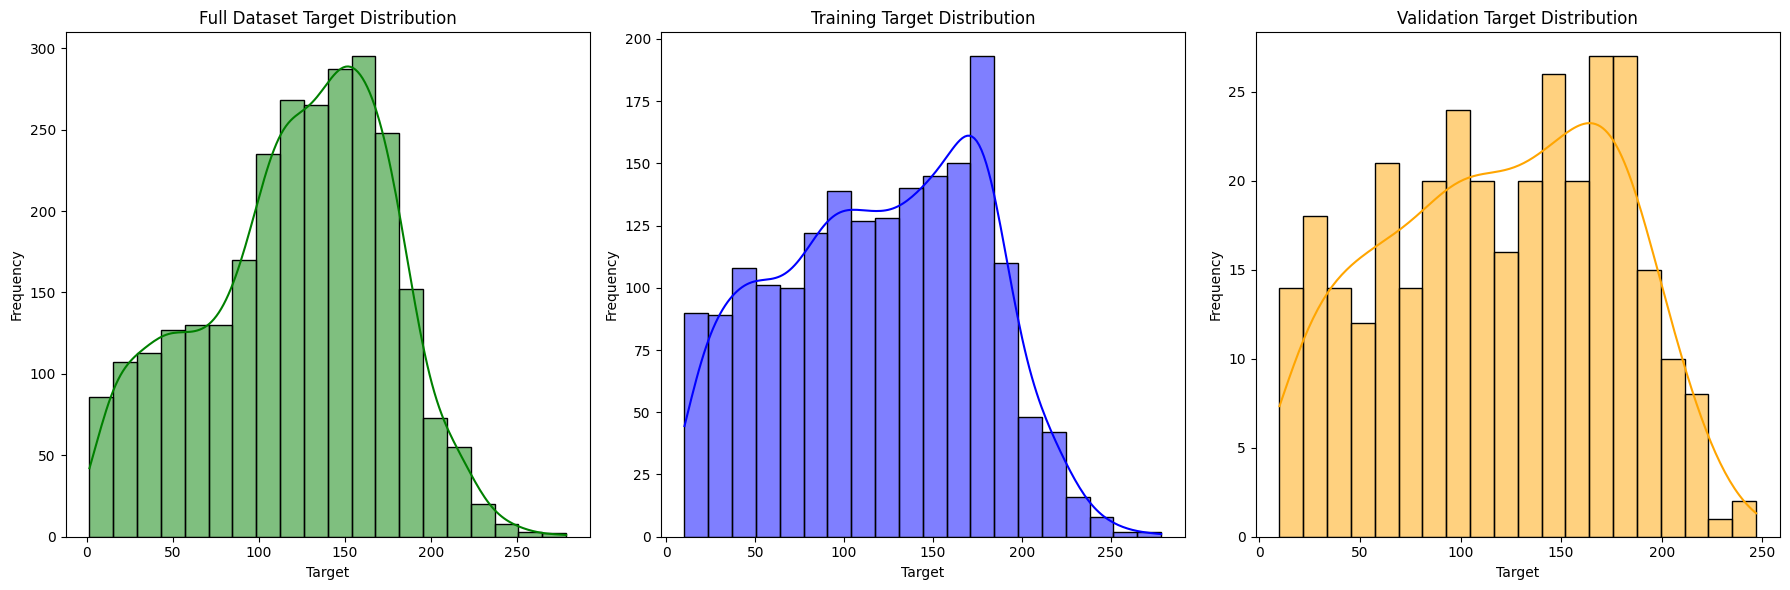

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable in the entire dataset, training, and validation sets
def plot_target_distribution(df_full, df_train, df_val):
    plt.figure(figsize=(18, 6))

    # Plot full dataset target distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df_full['targets'], bins=20, kde=True, color='green', label='Full Dataset Targets')
    plt.title('Full Dataset Target Distribution')
    plt.xlabel('Target')
    plt.ylabel('Frequency')

    # Plot training target distribution
    plt.subplot(1, 3, 2)
    sns.histplot(df_train['targets'], bins=20, kde=True, color='blue', label='Training Targets')
    plt.title('Training Target Distribution')
    plt.xlabel('Target')
    plt.ylabel('Frequency')

    # Plot validation target distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df_val['targets'], bins=20, kde=True, color='orange', label='Validation Targets')
    plt.title('Validation Target Distribution')
    plt.xlabel('Target')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Convert the full dataset to a DataFrame
df_full = dataset_to_dataframe(dataset_with_indices)

# Plot the distributions
plot_target_distribution(df_full, train_df, val_df)

In [ ]:
# Map the dataset to combine inputs
def map_dataset(image, nitrogen, location, mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI,
                median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI, target):
    return (image, nitrogen, location, mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI,\
            median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI), target

mapped_dataset = dataset_with_indices.map(map_dataset)

# Count the total number of batches in the dataset
total_batches = sum(1 for _ in mapped_dataset)
train_batches = int(0.8 * total_batches)
val_batches = int(0.2 * total_batches)

# Split the dataset based on batches
train_dataset = mapped_dataset.take(train_batches)
val_dataset = mapped_dataset.skip(train_batches).take(val_batches)

#  Check the number of batches in each split
print(f"Training dataset batches: {sum(1 for _ in train_dataset)}")
print(f"Validation dataset batches: {sum(1 for _ in val_dataset)}")

Training dataset batches: 69
Validation dataset batches: 17


Best result (22nd submission) :36.43

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

def focal_loss_regression(gamma=2.05, alpha=0.25):
    """
    Focal Loss for regression problems. This focuses on reducing large errors.

    Parameters:
    - gamma: Focusing parameter that reduces the relative loss for well-predicted examples (y_true close to y_pred).
    - alpha: Weighting factor for scaling the loss.
    """
    def loss(y_true, y_pred):
        error = y_true - y_pred
        squared_error = K.square(error)
        absolute_error = K.abs(error)
        focal_weight = K.pow(absolute_error, gamma)

        # Calculate the focal loss
        focal_loss = alpha * focal_weight * squared_error
        return K.mean(focal_loss, axis=-1)

    return loss


# Define the image input branch
image_input = layers.Input(shape=(11, 21, 6), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Define the location input branch
loc_input = layers.Input(shape=(4,), name='location_input')
y = layers.Dense(4, activation='relu')(loc_input)

# Define the nitrogen input branch
nitrogen_input = layers.Input(shape=(1,), name='nitrogen_input')
z = layers.Dense(4, activation='relu')(nitrogen_input)

# Define separate inputs for vegetation indices (mean)
ndvi_input = layers.Input(shape=(1,), name='ndvi_input')
evi_input = layers.Input(shape=(1,), name='evi_input')
savi_input = layers.Input(shape=(1,), name='savi_input')
gli_input = layers.Input(shape=(1,), name='gli_input')
ndre_input = layers.Input(shape=(1,), name='ndre_input')
gndvi_input = layers.Input(shape=(1,), name='gndvi_input')
ngrdi_input = layers.Input(shape=(1,), name='ngrdi_input')

# Define separate inputs for vegetation indices (median)
ndvi_input_m = layers.Input(shape=(1,), name='ndvi_input_m')
evi_input_m = layers.Input(shape=(1,), name='evi_input_m')
savi_input_m = layers.Input(shape=(1,), name='savi_input_m')
gli_input_m = layers.Input(shape=(1,), name='gli_input_m')
ndre_input_m = layers.Input(shape=(1,), name='ndre_input_m')
gndvi_input_m = layers.Input(shape=(1,), name='gndvi_input_m')
ngrdi_input_m = layers.Input(shape=(1,), name='ngrdi_input_m')

# Combine all vegetation indices (mean)
veg_combined = layers.concatenate([ndvi_input, evi_input, savi_input, gli_input, ndre_input, gndvi_input, ngrdi_input])

# Process the combined vegetation indices (mean)
veg_processed = layers.Dense(64, activation='relu')(veg_combined)
veg_processed = layers.Dense(32, activation='relu')(veg_processed)

# Combine all vegetation indices (median)
veg_combined_m = layers.concatenate([ndvi_input_m, evi_input_m, savi_input_m, gli_input_m, ndre_input_m, gndvi_input_m, ngrdi_input_m])

# Process the combined vegetation indices (median)
veg_processed_m = layers.Dense(64, activation='relu')(veg_combined_m)
veg_processed_m = layers.Dense(32, activation='relu')(veg_processed_m)

# Concatenate all branches (image, nitrogen, and processed vegetation indices)
concatenated = layers.concatenate([x, y, z, veg_processed, veg_processed_m])
concatenated = layers.Dense(32, activation='relu')(concatenated)
output = layers.Dense(1)(concatenated)

# Compile the model
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_rmse', factor=0.5, patience=30, min_lr=1e-8)
model = models.Model(inputs=[image_input, loc_input, nitrogen_input, ndvi_input, evi_input, savi_input,
                             gli_input, ndre_input, gndvi_input, ngrdi_input,
                             ndvi_input_m, evi_input_m, savi_input_m,
                             gli_input_m, ndre_input_m, gndvi_input_m, ngrdi_input_m], outputs=output)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError(name='rmse')])

model.summary()

# Train the model with the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_rmse', patience=150, restore_best_weights=True, mode='min')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1200,
    callbacks=[early_stopping]
)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 11, 21, 6)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 9, 19, 32)      │          1,760 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_58          │ (None, 4, 9, 32)       │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 2, 7, 64)       │         18,496 │ max_pooling2d_58[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ndvi_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ evi_input (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ savi_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gli_input (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ndre_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gndvi_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ngrdi_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ndvi_input_m (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ evi_input_m (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ savi_input_m (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gli_input_m (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ndre_input_m (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gndvi_input_m             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ngrdi_input_m             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 56,637 (221.24 KB)

 Trainable params: 56,637 (221.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 14729.8887 - rmse: 120.2497 - val_loss: 3305.3188 - val_rmse: 57.4919
Epoch 2/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3228.2698 - rmse: 56.8155 - val_loss: 3104.7705 - val_rmse: 55.7205
Epoch 3/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3084.5037 - rmse: 55.5358 - val_loss: 2985.7698 - val_rmse: 54.6422
Epoch 4/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2928.2937 - rmse: 54.1106 - val_loss: 2813.8420 - val_rmse: 53.0457
Epoch 5/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2733.3743 - rmse: 52.2767 - val_loss: 2589.3882 - val_rmse: 50.8860
Epoch 6/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2533.7109 - rmse: 50.3270 - val_loss: 2294.6978 - val_rmse: 47.9030
Epoch 7/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2357.7563 - rmse: 48.5450 - val_loss: 2162.1765 - val_rmse: 46.4992
Epoch 8/1200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2235.2397 - rmse: 47.2701 - val_loss

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


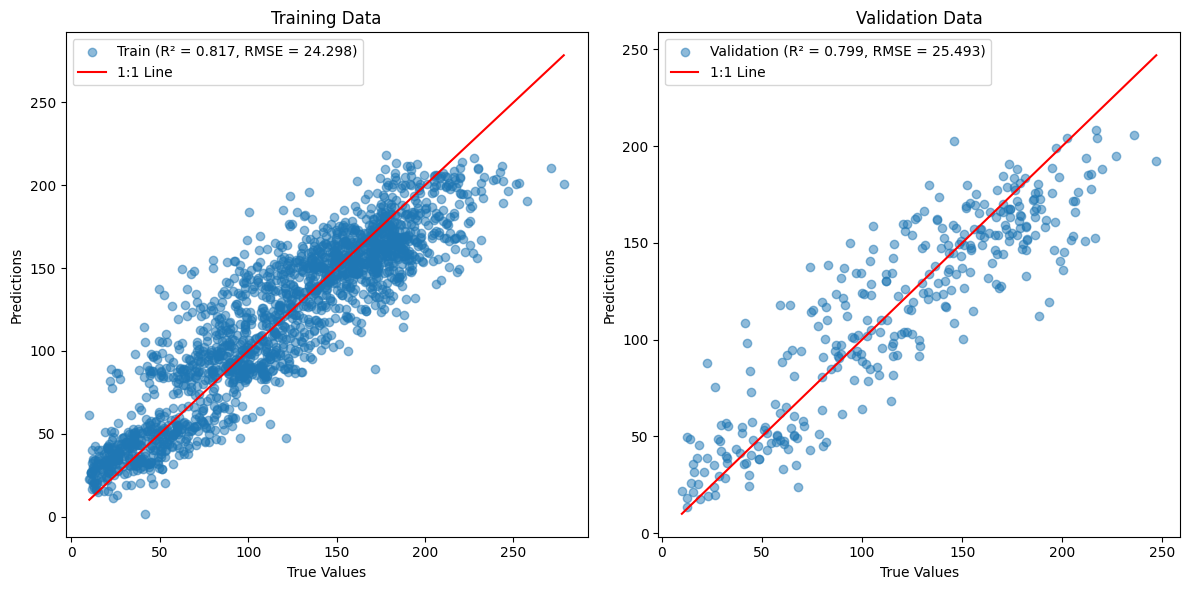

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Get predictions for training and validation datasets
train_predictions = model.predict(train_dataset)
val_predictions = model.predict(val_dataset)

# Extract ground truth labels from the datasets
train_labels = np.concatenate([y for x, y in train_dataset], axis=0)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Calculate R² and RMSE for training and validation datasets
train_r2 = r2_score(train_labels, train_predictions)
val_r2 = r2_score(val_labels, val_predictions)

train_rmse = np.sqrt(mean_squared_error(train_labels, train_predictions))
val_rmse = np.sqrt(mean_squared_error(val_labels, val_predictions))

# Plot predictions vs ground truth for the training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_labels, train_predictions, alpha=0.5, label=f'Train (R² = {train_r2:.3f}, RMSE = {train_rmse:.3f})')
plt.plot([min(train_labels), max(train_labels)], [min(train_labels), max(train_labels)], 'r', label='1:1 Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Training Data')
plt.legend()

# Plot predictions vs ground truth for the validation set
plt.subplot(1, 2, 2)
plt.scatter(val_labels, val_predictions, alpha=0.5, label=f'Validation (R² = {val_r2:.3f}, RMSE = {val_rmse:.3f})')
plt.plot([min(val_labels), max(val_labels)], [min(val_labels), max(val_labels)], 'r', label='1:1 Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Validation Data')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/'+'best_submission_35p23.keras')

In [ ]:
test_path='/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test'

path_to_files=os.listdir(test_path)
paths_to_image_files=[os.path.join(test_path,x) for x in path_to_files if x=='Satellite']
image_path_location=[os.listdir(x) for x in paths_to_image_files]
print(image_path_location[0])

print(image_path_location,paths_to_image_files)
groundtruth_path1= os.path.join(test_path,'GroundTruth/test_HIPS_HYBRIDS_2023_V2.3.csv')
groundtruth_path2= os.path.join(test_path,'GroundTruth/DateofCollection.xlsx')
data=pd.read_csv(groundtruth_path1)
Date=pd.read_excel(groundtruth_path2)

Test_All_Path, Test_All_target, Test_All_loc, Test_All_Ninfo = get_filepath_target(data, Date, image_path_location)

['.DS_Store', 'Ames']
[['.DS_Store', 'Ames']] ['/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite']
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/Ames/TP1/Ames-TP1-2315_9_15.TIF, Timepoint of image TP1 = Series([], )
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/Ames/TP2/Ames-TP2-2315_9_15.TIF, Timepoint of image TP2 = Series([], )
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/Ames/TP3/Ames-TP3-2315_9_15.TIF, Timepoint of image TP3 = Series([], )
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/Ames/TP1/Ames-TP1-2315_7_11.TIF, Timepoint of image TP1 = Series([], )
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/Ames/TP2/Ames-TP2-2315_7_11.TIF, Timepoint of image TP2 = Series([], )
/content/drive/MyDrive/Colab Notebooks/Competition/Data Unzipped/test/Test/Satellite/

In [ ]:
def compute_vegetation_indices(image):
    R = image[..., 0]
    G = image[..., 1]
    B = image[..., 2]
    NIR = image[..., 3]
    RE = image[..., 4]

    NDVI = (NIR - R) / (NIR + R)
    EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))
    SAVI = 1.5 * (NIR - R) / (NIR + R + 0.5)
    GLI = (2 * G - R - B) / (2 * G + R + B)
    NDRE = (NIR - RE) / (NIR + RE)
    GNDVI = (NIR - G) / (NIR + G)
    NGRDI = (R - G) / (R + G)

    # Handle NaNs
    NDVI = tf.where(tf.math.is_nan(NDVI), tf.zeros_like(NDVI), NDVI)
    EVI = tf.where(tf.math.is_nan(EVI), tf.zeros_like(EVI), EVI)
    SAVI = tf.where(tf.math.is_nan(SAVI), tf.zeros_like(SAVI), SAVI)
    GLI = tf.where(tf.math.is_nan(GLI), tf.zeros_like(GLI), GLI)
    NDRE = tf.where(tf.math.is_nan(NDRE), tf.zeros_like(NDRE), NDRE)
    GNDVI = tf.where(tf.math.is_nan(GNDVI), tf.zeros_like(GNDVI), GNDVI)
    NGRDI = tf.where(tf.math.is_nan(NGRDI), tf.zeros_like(NGRDI), NGRDI)

    # Calculate mean for each vegetation index across the spatial dimensions
    mean_NDVI = np.mean(NDVI)
    mean_EVI = np.mean(EVI)
    mean_SAVI = np.mean(SAVI)
    mean_GLI = np.mean(GLI)
    mean_NDRE = np.mean(NDRE)
    mean_GNDVI = np.mean(GNDVI)
    mean_NGRDI = np.mean(NGRDI)

    # Calculate median for each vegetation index across the spatial dimensions
    median_NDVI = np.median(NDVI)
    median_EVI = np.median(EVI)
    median_SAVI = np.median(SAVI)
    median_GLI = np.median(GLI)
    median_NDRE = np.median(NDRE)
    median_GNDVI = np.median(GNDVI)
    median_NGRDI = np.median(NGRDI)

    return mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI

In [ ]:
# Load the trained model
model.save('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/'+'best_submission_35p23.keras')
# model = tf.keras.models.load_model('/content/drive/MyDrive/Competition/Submitted_models/cnn_regressionwithmoreinfo_modelNDVIfea_v2_S22.h5')
encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/location_encoder.pkl')

results = []
for i in range(len(Test_All_Path)):
    image_path = Test_All_Path[i]  # Path to the image file
    new_image = average_images(image_path)  # Process the image

    # Compute vegetation indices (mean and median)
    mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
    median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI = compute_vegetation_indices(new_image)

    # Prepare the input data for prediction
    new_images = np.expand_dims(new_image, axis=0)  # Add batch dimension

    location = Test_All_loc[i]      # Location data
    loc_encoded = encoder.transform(np.array(location).reshape(-1, 1))

    # Prepare nitrogen and vegetation index inputs
    nitrogen = np.array(Test_All_Ninfo[i]).reshape(1, 1)

    mean_NDVI = np.array(mean_NDVI).reshape(1, 1)
    mean_EVI = np.array(mean_EVI).reshape(1, 1)
    mean_SAVI = np.array(mean_SAVI).reshape(1, 1)
    mean_GLI = np.array(mean_GLI).reshape(1, 1)
    mean_NDRE = np.array(mean_NDRE).reshape(1, 1)
    mean_GNDVI = np.array(mean_GNDVI).reshape(1, 1)
    mean_NGRDI = np.array(mean_NGRDI).reshape(1, 1)

    median_NDVI = np.array(median_NDVI).reshape(1, 1)
    median_EVI = np.array(median_EVI).reshape(1, 1)
    median_SAVI = np.array(median_SAVI).reshape(1, 1)
    median_GLI = np.array(median_GLI).reshape(1, 1)
    median_NDRE = np.array(median_NDRE).reshape(1, 1)
    median_GNDVI = np.array(median_GNDVI).reshape(1, 1)
    median_NGRDI = np.array(median_NGRDI).reshape(1, 1)

    # Combine all inputs for prediction
    new_data = (
        new_images, loc_encoded, nitrogen,
        mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI,
        median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI
    )

    # Predict using the model
    predictions = model.predict(new_data)

    # Store the results
    results.append({
        'File Path': image_path[0],
        'Predicted Yield': predictions[0][0]
    })

    # Print the prediction
    print(f'Predicted yield: {predictions[0][0]}')

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
excel_file = 'predictions.xlsx'
df.to_excel(excel_file, index=False)

# Download the file
files.download(excel_file)

print(f'Predictions saved to {excel_file}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted yield: 149.66285705566406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted yield: 159.61912536621094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted yield: 158.1470489501953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted yield: 159.00120544433594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted yield: 139.56875610351562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted yield: 171.1496124267578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted yield: 137.45172119140625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted yield: 171.48646545410156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted yield: 158.40194702148438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted yield: 146.3543701171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted yield: 128.72264099121094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted yield: 162.1536102294922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted yield: 150.21905517578125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Pre

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved to predictions.xlsx


In [ ]:
# Load the trained model
# model.save('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/'+'best_submission_35p23.keras')
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/'+'best_submission_35p23.keras')
encoder = joblib.load('/content/drive/MyDrive/Colab Notebooks/Competition/Submitted_models/location_encoder.pkl')

results = []
for i in range(len(Test_All_Path)):
    image_path = Test_All_Path[i]  # Path to the image file
    new_image = average_images(image_path)  # Process the image

    # Compute vegetation indices (mean and median)
    mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI, \
    median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI = compute_vegetation_indices(new_image)

    # Prepare the input data for prediction
    new_images = np.expand_dims(new_image, axis=0)  # Add batch dimension

    location = Test_All_loc[i]      # Location data
    loc_encoded = encoder.transform(np.array(location).reshape(-1, 1))

    # Prepare nitrogen and vegetation index inputs
    nitrogen = np.array(Test_All_Ninfo[i]).reshape(1, 1)

    mean_NDVI = np.array(mean_NDVI).reshape(1, 1)
    mean_EVI = np.array(mean_EVI).reshape(1, 1)
    mean_SAVI = np.array(mean_SAVI).reshape(1, 1)
    mean_GLI = np.array(mean_GLI).reshape(1, 1)
    mean_NDRE = np.array(mean_NDRE).reshape(1, 1)
    mean_GNDVI = np.array(mean_GNDVI).reshape(1, 1)
    mean_NGRDI = np.array(mean_NGRDI).reshape(1, 1)

    median_NDVI = np.array(median_NDVI).reshape(1, 1)
    median_EVI = np.array(median_EVI).reshape(1, 1)
    median_SAVI = np.array(median_SAVI).reshape(1, 1)
    median_GLI = np.array(median_GLI).reshape(1, 1)
    median_NDRE = np.array(median_NDRE).reshape(1, 1)
    median_GNDVI = np.array(median_GNDVI).reshape(1, 1)
    median_NGRDI = np.array(median_NGRDI).reshape(1, 1)

    # Combine all inputs for prediction
    new_data = (
        new_images, loc_encoded, nitrogen,
        mean_NDVI, mean_EVI, mean_SAVI, mean_GLI, mean_NDRE, mean_GNDVI, mean_NGRDI,
        median_NDVI, median_EVI, median_SAVI, median_GLI, median_NDRE, median_GNDVI, median_NGRDI
    )

    # Predict using the model
    predictions = model.predict(new_data)

    # Store the results
    results.append({
        'File Path': image_path[0],
        'Predicted Yield': predictions[0][0]
    })

    # Print the prediction
    print(f'Predicted yield: {predictions[0][0]}')

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
excel_file = 'predictions.xlsx'
df.to_excel(excel_file, index=False)

# Download the file
files.download(excel_file)

print(f'Predictions saved to {excel_file}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
Predicted yield: 149.66285705566406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted yield: 159.61912536621094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted yield: 158.1470489501953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted yield: 159.00120544433594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted yield: 139.56875610351562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted yield: 171.1496124267578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted yield: 137.45172119140625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted yield: 171.48646545410156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted yield: 158.40194702148438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted yield: 146.3543701171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted yield: 128.72264099121094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted yield: 162.1536102294922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted yield: 150.21905517578125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Pr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved to predictions.xlsx
